# Algorithm Benchmarks

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats          import pearsonr
from statsmodels.api import OLS
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import LinearSVC 
from sklearn.svm import SVC
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
#sourced from sklearn documentation
def correlation(dataset, threshold):
    col_corr = set() # Set of all names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [3]:
os.getcwd()

'C:\\Users\\dkestenbaum\\Desktop\\SML Individual Project'

## Credit Card Default Data

* cust_id (numeric)
* X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* X2: Gender (1 = male; 2 = female).
* X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* X4: Marital status (1 = married; 2 = single; 3 = others).
* X5: Age (year).
* X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
* X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
* X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.
* default.payment.next.month: binary variable, default payment (Yes = 1, No = 0)

## Linear Regression Benchmark

Here I will implement `statmodles`' linear regression model to predict `LIMIT_BAL`. While I'm aware that this dataset is intended for classification. I wanted to demonstrate my knowledge and undertsanding of linear regression as it was the first algorithm learned in this course. 

In [4]:
#read the data
train_df = pd.read_csv('credit_default_train.csv')

In [5]:
train_df.head()

,cust_id,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,18895,70000.0,1.0,3.0,2.0,34.0,0.0,0.0,0.0,0.0,...,25559.0,26134.0,26715.0,1700.0,1500.0,2000.0,1000.0,1000.0,2000.0,0
1,25102,390000.0,2.0,2.0,2.0,26.0,2.0,2.0,2.0,0.0,...,140387.0,128112.0,115514.0,5000.0,3000.0,5000.0,4548.0,4100.0,3300.0,0
2,28867,60000.0,1.0,1.0,2.0,27.0,0.0,0.0,0.0,0.0,...,26038.0,28607.0,27997.0,1378.0,1406.0,3000.0,3000.0,0.0,923.0,1
3,1842,140000.0,2.0,2.0,1.0,55.0,0.0,0.0,0.0,0.0,...,72391.0,61298.0,62193.0,4200.0,2822.0,2336.0,2588.0,2250.0,2491.0,0
4,3371,50000.0,1.0,1.0,2.0,29.0,2.0,2.0,2.0,0.0,...,1047.0,0.0,0.0,3000.0,0.0,1000.0,0.0,0.0,0.0,1


In [6]:
#fill nas with 0 for now
#train_df.fillna(value=0,axis=0,inplace=True)

# EDA

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cust_id                     20000 non-null  int64  
 1   LIMIT_BAL                   19798 non-null  float64
 2   SEX                         19839 non-null  float64
 3   EDUCATION                   19801 non-null  float64
 4   MARRIAGE                    19830 non-null  float64
 5   AGE                         19786 non-null  float64
 6   PAY_0                       19805 non-null  float64
 7   PAY_2                       19781 non-null  float64
 8   PAY_3                       19783 non-null  float64
 9   PAY_4                       19801 non-null  float64
 10  PAY_5                       19815 non-null  float64
 11  PAY_6                       19797 non-null  float64
 12  BILL_AMT1                   19815 non-null  float64
 13  BILL_AMT2                   197

<AxesSubplot:>

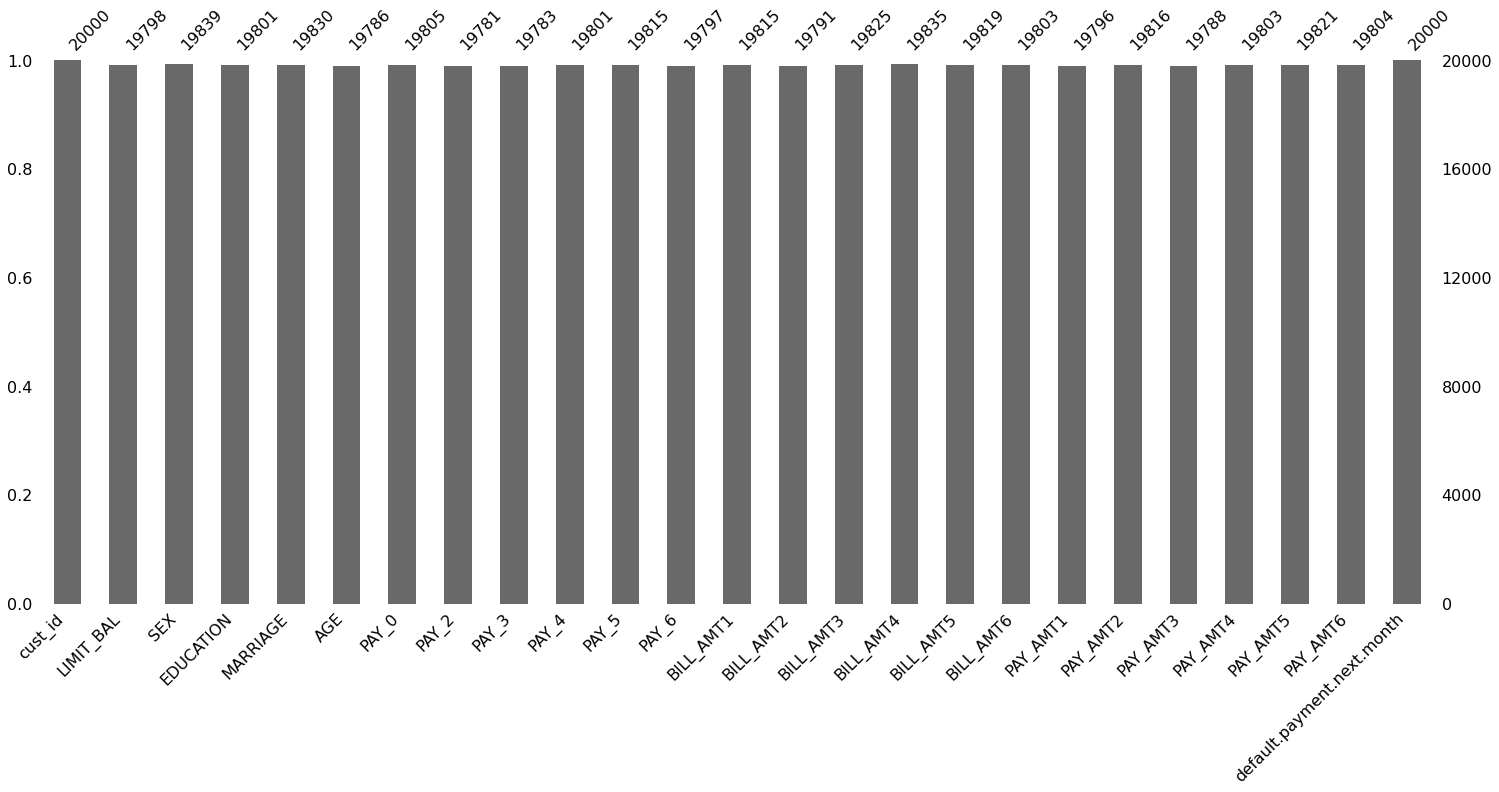

In [8]:
#visualize missing values
msno.bar(train_df)

*Relatively few NAs*

## Missing Value Imputation

In [9]:
train_df.dtypes

cust_id                         int64
LIMIT_BAL                     float64
SEX                           float64
EDUCATION                     float64
MARRIAGE                      float64
AGE                           float64
PAY_0                         float64
PAY_2                         float64
PAY_3                         float64
PAY_4                         float64
PAY_5                         float64
PAY_6                         float64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

In [10]:
#list comprehension to put column labels of categorical columns in a list
#cat_cols = [col for col in train_df.columns if train_df[col].dtype == 'object']

#numeric_cols = [col for col in train_df.columns if train_df[col].dtype != 'object']

In [11]:
#seperate categorical and numerical columns
#cat_cols = train_df.iloc[:,2:6].columns

#numeric_cols = [col for col in train_df.columns if col not in cat_cols]

In [12]:
#list comprehension to put column labels of columns with null values in a list
cols_with_missings = [col for col in train_df.columns if train_df[col].isnull().sum() > 0]

In [13]:
#create function
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_freq = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for col in train_df[cols_with_missings].columns:
    if col in ['SEX','EDUCATION','MARRIAGE']:
        imp_freq=imp_freq.fit(train_df[[col]])
        train_df[col] = imp_freq.transform(train_df[[col]])
    else:
        imp_mean=imp_mean.fit(train_df[[col]])
        train_df[col] = imp_mean.transform(train_df[[col]])

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cust_id                     20000 non-null  int64  
 1   LIMIT_BAL                   20000 non-null  float64
 2   SEX                         20000 non-null  float64
 3   EDUCATION                   20000 non-null  float64
 4   MARRIAGE                    20000 non-null  float64
 5   AGE                         20000 non-null  float64
 6   PAY_0                       20000 non-null  float64
 7   PAY_2                       20000 non-null  float64
 8   PAY_3                       20000 non-null  float64
 9   PAY_4                       20000 non-null  float64
 10  PAY_5                       20000 non-null  float64
 11  PAY_6                       20000 non-null  float64
 12  BILL_AMT1                   20000 non-null  float64
 13  BILL_AMT2                   200

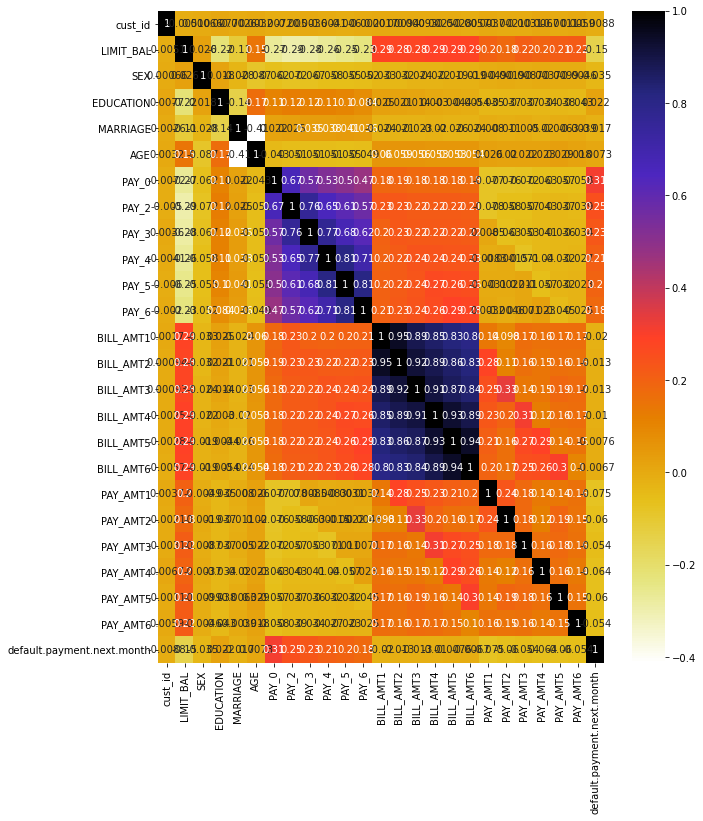

In [15]:
#check for multicollinearity
#pearson correlation matrix to explore feature correlation

plt.figure(figsize=(10,12))
cor = train_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

*Some collinearity is present*

In [16]:
correlated_features = correlation(train_df,0.7)

In [17]:
multicollinearity = list(correlated_features)

In [18]:
#sourced from a previous project: https://github.com/dimitrik1223/DSC-Donations-Predictions/blob/main/PDA_group_FINAL.ipynb


selectedFeatures = []
target = "LIMIT_BAL"

for column in train_df.columns:
    if column not in ("cust_id","LIMIT_BAL"):
        (pearson,pvalue) = pearsonr(train_df[column],train_df[target])
        print(f"{column} - p-vlue = {pvalue} - selected : {1 if pvalue < 0.001 else 0}")
        if pvalue < 0.001:
            selectedFeatures.append(column)

SEX - p-vlue = 0.0002311441313752747 - selected : 1
EDUCATION - p-vlue = 3.5045004972416e-208 - selected : 1
MARRIAGE - p-vlue = 5.177379836426521e-56 - selected : 1
AGE - p-vlue = 2.9365222148469818e-96 - selected : 1
PAY_0 - p-vlue = 8e-323 - selected : 1
PAY_2 - p-vlue = 0.0 - selected : 1
PAY_3 - p-vlue = 0.0 - selected : 1
PAY_4 - p-vlue = 6.51306e-318 - selected : 1
PAY_5 - p-vlue = 3.826046445420621e-277 - selected : 1
PAY_6 - p-vlue = 6.1770442820646965e-242 - selected : 1
BILL_AMT1 - p-vlue = 0.0 - selected : 1
BILL_AMT2 - p-vlue = 0.0 - selected : 1
BILL_AMT3 - p-vlue = 0.0 - selected : 1
BILL_AMT4 - p-vlue = 0.0 - selected : 1
BILL_AMT5 - p-vlue = 0.0 - selected : 1
BILL_AMT6 - p-vlue = 0.0 - selected : 1
PAY_AMT1 - p-vlue = 2.343272433870715e-180 - selected : 1
PAY_AMT2 - p-vlue = 8.542693574221572e-145 - selected : 1
PAY_AMT3 - p-vlue = 2.7065806916878046e-209 - selected : 1
PAY_AMT4 - p-vlue = 2.174302260651989e-176 - selected : 1
PAY_AMT5 - p-vlue = 2.3857572760006975e-2

In [19]:
#subset for only statistically significant features
X = train_df[selectedFeatures]
#add id
X['cust_id'] = train_df["cust_id"]

#create response vector 
y = train_df[['LIMIT_BAL']]

C:\Users\DKESTE~1\AppData\Local\Temp/ipykernel_16412/711861952.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cust_id'] = train_df["cust_id"]


In [20]:
#drop correlated features
X.drop(columns=multicollinearity,axis=1,inplace=True)

C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [21]:
X = sm.add_constant(X)
y = np.squeeze(np.asarray(y))

In [22]:
model = OLS(y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     676.2
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        10:59:34   Log-Likelihood:            -2.5960e+05
No. Observations:               20000   AIC:                         5.192e+05
Df Residuals:                   19984   BIC:                         5.194e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       1.472e+05   6002.076     24.525      0.000    1.35e+05    1.59e+05
SEX                         6673.1641   1535.896      4.345      0.000    3662.681    9683.648
EDUCATION                  -3.206e+04    974.478    -32.895      0.000    -3.4e+04   -3.01e+04
MARRIAGE                   -1.849e+04   1573.364    -11.754      0.000   -2.16e+04   -1.54e+04
AGE                         1510.1148     90.499     16.687      0.000    1332.729    1687.500
PAY_0                      -1.209e+04    922.873    -13.096      0.000   -1.39e+04   -1.03e+04
PAY_2                      -2.475e+04    854.676    -28.960      0.000   -2.64e+04   -2.31e+04
BILL_AMT1                      0.5070      0.011     46.143      0.000       0.485       0.529
PAY_AMT1                       0.5183      0.052      9.956      0.000       0.416       0.620
PAY_AMT2                       0.3074      0.036      8.653      0.000       0.238       0.377
PAY_AMT3                       0.5506      0.045     12.174      0.000       0.462       0.639
PAY_AMT4                       0.6116      0.050     12.132      0.000       0.513       0.710
PAY_AMT5                       0.6830      0.051     13.295      0.000       0.582       0.784
PAY_AMT6                       0.6500      0.043     15.097      0.000       0.566       0.734
default.payment.next.month -6195.7695   1900.947     -3.259      0.001   -9921.783   -2469.756
cust_id                       -0.1117      0.086     -1.306      0.192      -0.279       0.056
==============================================================================
Omnibus:                     3104.097   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5256.051
Skew:                           1.032   Prob(JB):                         0.00
Kurtosis:                       4.432   Cond. No.                     7.54e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.54e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
model.ssr

220199324852992.28

## `Train` / `Test` Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123)

In [26]:
lr = LinearRegression()

lr.fit(X_train,y_train)

y_preds = lr.predict(X_test)

In [27]:
df = pd.DataFrame({'Actual': y_test, 'Predicted':
y_preds})
  
print(' residual sum of squares is : '+ str(np.sum(np.square(df['Predicted'] - df['Actual']))))

 residual sum of squares is : 66039942348237.66


## Logistic Regression Benchmark

In [28]:
#seperate the features from the response variable (default.payment.next.month)
X = train_df.iloc[:,:24]
y = np.array(train_df['default.payment.next.month'])

In [29]:
#initiate sklearn's logistic regression
log_reg_mod = LogisticRegression() #class_weight = 'balanced'
#forward stepwise feature selection
for_step_select_log_reg = sfs(log_reg_mod, k_features=8, forward=True, verbose=2, scoring='accuracy')

In [32]:
# #fit the forward stepwise selection class to the data
# for_step_select_log_reg = for_step_select_log_reg.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    3.0s finished

[2022-03-28 16:38:40] Features: 1/8 -- score: 0.8170999999999999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    3.9s finished

[2022-03-28 16:38:44] Features: 2/8 -- score: 0.8160999999999999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    6.7s finished

[2022-03-28 16:38:51] Features: 3/8 -- score: 0.8155000000000001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

['EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [103]:
# best_feats_log_reg = list(for_step_select_log_reg.k_feature_names_)
# print(best_feats_log_reg)

['EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


* Below attempting to stratify y resulted in an error.

In [30]:
#subset X for best features from forward stepwise selection only
best_feats_log_reg = ['EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
X = X[best_feats_log_reg]

In [31]:
#stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123,stratify=y)

In [32]:
log_reg_mod.fit(X_train,y_train)

y_preds = log_reg_mod.predict(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds, pos_label=1)

metrics.auc(fpr, tpr)

0.6076503660783742

# Decision Tree Classifier

In [33]:
#seperate the features from the response variable (default.payment.next.month)
X = train_df.iloc[:,:24]
y = np.array(train_df['default.payment.next.month'])

In [41]:
# clf = DecisionTreeClassifier(random_state=0)

# for_step_select_clf = sfs(clf, k_features=20, forward=True, verbose=2, scoring='accuracy')
# #fit the forward stepwise selection class to the data
# for_step_select_clf = for_step_select_clf.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    3.3s finished

[2022-03-28 16:40:35] Features: 1/20 -- score: 0.8167499999999999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    2.7s finished

[2022-03-28 16:40:37] Features: 2/20 -- score: 0.81745[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    2.9s finished

[2022-03-28 16:40:40] Features: 3/20 -- score: 0.81755[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapse

In [42]:
# best_feats_clf = list(for_step_select_clf.k_feature_names_)
# print(best_feats_clf)

['cust_id', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT4', 'PAY_AMT5']


In [34]:
#subset X for best features from forward stepwise selection only
best_feats_clf = ['cust_id', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT4', 'PAY_AMT5']
X = X[best_feats_clf]

In [35]:
#stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123,stratify=y)

In [98]:
cv_clf = cross_val_score(clf, X_train, y_train, cv=10)

In [99]:
cv_clf

array([0.72714286, 0.72214286, 0.71714286, 0.715     , 0.72142857,
       0.74142857, 0.71785714, 0.72142857, 0.71142857, 0.71785714])

In [108]:
# #create params dictionary
# param_dict = {
#     'criterion':['gini','entropy'],
#     "max_depth": range(1,5),
#     "min_samples_split": range(1,5),
#     "min_samples_leaf": range(1,5)
# }

# grid = GridSearchCV(clf,
#                    param_grid=param_dict,
#                    cv=5,
#                    verbose=1,
#                    n_jobs=-1)
# grid.fit(X_train,y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
160 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\tree\_classes.py", line 250, in fit
    raise ValueError(
ValueError: min_samples_split must be an integer greater than 1 or a f

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 5),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 5)},
             verbose=1)

In [110]:
# print(grid.best_params_)
# print(grid.best_estimator_)

{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecisionTreeClassifier(max_depth=1, random_state=0)


{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecisionTreeClassifier(max_depth=1, random_state=0)

In [36]:
clf = DecisionTreeClassifier(criterion='gini',max_depth=1,min_samples_leaf=1,min_samples_split=2)

In [37]:
clf.fit(X_train,y_train)

y_preds = clf.predict(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds, pos_label=1)

metrics.auc(fpr, tpr)

0.6376021155789414

# Random Forest Classifier

In [38]:
#seperate the features from the response variable (default.payment.next.month)
X = train_df.iloc[:,:24]
y = np.array(train_df['default.payment.next.month'])

In [49]:
# rf_clf = RandomForestClassifier(random_state=123)

# for_step_select_rf = sfs(rf_clf, k_features=20, forward=True, verbose=2, scoring='accuracy')
# #fit the forward stepwise selection class to the data
# for_step_select_rf = for_step_select_rf.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  3.2min finished

[2022-03-28 16:49:49] Features: 1/20 -- score: 0.8167499999999999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:  2.4min finished

[2022-03-28 16:52:14] Features: 2/20 -- score: 0.81755[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:  2.1min finished

[2022-03-28 16:54:17] Features: 3/20 -- score: 0.8178000000000001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of  

In [60]:
# best_feats_rf = list(for_step_select_rf.k_feature_names_)
# print(best_feats_rf)

['cust_id', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT4', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT5', 'PAY_AMT6']


In [40]:
#subset X for best features from forward stepwise selection only
best_feats_rf = ['cust_id', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT4', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT5', 'PAY_AMT6']
X = X[best_feats_rf]

In [45]:
#stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123,stratify=y)

In [121]:
#create params dictionary
# param_dict = {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800]}


# grid = GridSearchCV(rf_clf,
#                    param_grid=param_dict,
#                    cv=5,
#                    verbose=1,
#                    n_jobs=-1)

# grid.fit(X_train,y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 400, 600, 800]},
             verbose=1)

In [ ]:
rf = RandomForestClassifier()
param_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [130, 180, 230,1000]}
grid = RandomizedSearchCV(rf,param_grid,n_iter=50,random_state=123,verbose=3)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=230;, score=0.816 total time= 1.0min
[CV 2/5] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=230;, score=0.817 total time= 1.3min
[CV 3/5] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=230;, score=0.816 total time= 1.2min
[CV 4/5] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=230;, score=0.821 total time=  58.7s
[CV 5/5] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=230;, score=0.819 total time=  57.7s
[CV 1/5] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=130;, score=0.809 total time= 1.0min
[CV 2/5] END b

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=123)

In [122]:
# print(grid.best_params_)
# print(grid.best_estimator_)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=123)


In [52]:
rf_clf = RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=1000, random_state=123)

rf_clf.fit(X_train,y_train)

y_preds = rf_clf.predict(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds, pos_label=1)

metrics.auc(fpr, tpr)

0.653996405202755

# SVM

In [55]:
SVM_clf = LinearSVC() #using linear kernel
for_step_select_SVM = sfs(SVM_clf, k_features=20, forward=True, verbose=2, scoring='accuracy')
#fit the forward stepwise selection class to the data
for_step_select_SVM = for_step_select_rf.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.3min finished

[2022-03-28 17:34:37] Features: 1/20 -- score: 0.8167499999999999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:  1.8min finished

[2022-03-28 17:36:23] Features: 2/20 -- score: 0.81755[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.6min finished

[2022-03-28 17:37:57] Features: 3/20 -- score: 0.8178000000000001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of  

In [68]:
SVM_clf = LinearSVC() #using linear kernel

In [61]:
best_feats_SVM = list(for_step_select_SVM.k_feature_names_)
print(best_feats_SVM)

['cust_id', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT4', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT5', 'PAY_AMT6']


In [62]:
#subset X for best features from forward stepwise selection only
X = X[best_feats_SVM]

In [116]:
#stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=123,stratify=y)

In [66]:
SVM_clf

SVC()

In [93]:
# defining parameter range
param_grid = { 'C':[0.1,1,100,1000],'loss':['hinge','squared_hinge'],'class_weight':[None,'balanced'],'max_iter':[500,1000,2000]}
grid = RandomizedSearchCV(SVM_clf,param_grid,verbose=3)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, loss=hinge, max_iter=1000;, score=0.779 total time=   1.3s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, loss=hinge, max_iter=1000;, score=0.780 total time=   1.3s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, loss=hinge, max_iter=1000;, score=0.778 total time=   1.2s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, loss=hinge, max_iter=1000;, score=0.769 total time=   2.1s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, loss=hinge, max_iter=1000;, score=0.480 total time=   1.4s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, loss=squared_hinge, max_iter=1000;, score=0.779 total time=   2.3s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, loss=squared_hinge, max_iter=1000;, score=0.252 total time=   1.4s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, loss=squared_hinge, max_iter=1000;, score=0.777 total time=   1.4s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, loss=squared_hinge, max_iter=1000;, score=0.569 total time=   1.9s
[CV 5/5] END C=0.1, class_weight=balanced, loss=squared_hinge, max_iter=1000;, score=0.406 total time=   1.8s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=100, class_weight=None, loss=squared_hinge, max_iter=1000;, score=0.592 total time=   1.8s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=100, class_weight=None, loss=squared_hinge, max_iter=1000;, score=0.579 total time=   1.4s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END C=100, class_weight=None, loss=squared_hinge, max_iter=1000;, score=0.515 total time=   1.2s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=100, class_weight=None, loss=squared_hinge, max_iter=1000;, score=0.264 total time=   1.4s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=100, class_weight=None, loss=squared_hinge, max_iter=1000;, score=0.485 total time=   1.4s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=1000, class_weight=balanced, loss=squared_hinge, max_iter=1000;, score=0.778 total time=   1.1s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=1000, class_weight=balanced, loss=squared_hinge, max_iter=1000;, score=0.775 total time=   1.3s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END C=1000, class_weight=balanced, loss=squared_hinge, max_iter=1000;, score=0.225 total time=   1.1s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=1000, class_weight=balanced, loss=squared_hinge, max_iter=1000;, score=0.779 total time=   1.2s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=1000, class_weight=balanced, loss=squared_hinge, max_iter=1000;, score=0.538 total time=   1.3s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, loss=hinge, max_iter=2000;, score=0.765 total time=   2.6s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, loss=hinge, max_iter=2000;, score=0.779 total time=   2.7s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END C=1, class_weight=None, loss=hinge, max_iter=2000;, score=0.763 total time=   2.3s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=1, class_weight=None, loss=hinge, max_iter=2000;, score=0.756 total time=   2.6s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=1, class_weight=None, loss=hinge, max_iter=2000;, score=0.252 total time=   2.5s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=100, class_weight=None, loss=hinge, max_iter=1000;, score=0.320 total time=   1.3s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=100, class_weight=None, loss=hinge, max_iter=1000;, score=0.594 total time=   1.3s
[CV 3/5] END C=100, class_weight=None, loss=hinge, max_iter=1000;, score=0.747 total time=   1.3s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=100, class_weight=None, loss=hinge, max_iter=1000;, score=0.282 total time=   1.2s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=100, class_weight=None, loss=hinge, max_iter=1000;, score=0.374 total time=   1.4s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, loss=hinge, max_iter=500;, score=0.779 total time=   0.6s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, loss=hinge, max_iter=500;, score=0.221 total time=   0.6s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, loss=hinge, max_iter=500;, score=0.730 total time=   0.7s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, loss=hinge, max_iter=500;, score=0.725 total time=   0.5s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, loss=hinge, max_iter=500;, score=0.396 total time=   0.6s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=100, class_weight=balanced, loss=squared_hinge, max_iter=2000;, score=0.776 total time=   2.4s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=100, class_weight=balanced, loss=squared_hinge, max_iter=2000;, score=0.719 total time=   2.6s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END C=100, class_weight=balanced, loss=squared_hinge, max_iter=2000;, score=0.573 total time=   2.9s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=100, class_weight=balanced, loss=squared_hinge, max_iter=2000;, score=0.505 total time=   2.6s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=100, class_weight=balanced, loss=squared_hinge, max_iter=2000;, score=0.515 total time=   2.6s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, loss=hinge, max_iter=2000;, score=0.333 total time=   2.7s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, loss=hinge, max_iter=2000;, score=0.582 total time=   2.9s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, loss=hinge, max_iter=2000;, score=0.663 total time=   2.5s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, loss=hinge, max_iter=2000;, score=0.771 total time=   2.7s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, loss=hinge, max_iter=2000;, score=0.558 total time=   3.0s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=100, class_weight=None, loss=squared_hinge, max_iter=500;, score=0.714 total time=   0.6s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=100, class_weight=None, loss=squared_hinge, max_iter=500;, score=0.779 total time=   0.5s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END C=100, class_weight=None, loss=squared_hinge, max_iter=500;, score=0.696 total time=   0.6s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=100, class_weight=None, loss=squared_hinge, max_iter=500;, score=0.779 total time=   0.6s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=100, class_weight=None, loss=squared_hinge, max_iter=500;, score=0.538 total time=   0.5s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RandomizedSearchCV(estimator=LinearSVC(C=1000, class_weight='balanced',
                                       loss='hinge', max_iter=500),
                   param_distributions={'C': [0.1, 1, 100, 1000],
                                        'class_weight': [None, 'balanced'],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'max_iter': [500, 1000, 2000]},
                   verbose=3)

In [ ]:
SVM = SVC()
#create params dictionary
param_dict = param_grid = {'C': [10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','poly']}


grid = RandomizedSearchCV(SVM,
                   param_dict,
                   n_iter=50,
                   cv=3,
                   verbose=3,
                   n_jobs=-1)

grid.fit(X_train,y_train)

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 30 is smaller than n_iter=50. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [71]:
print(grid.best_params_)
print(grid.best_estimator_)

{'max_iter': 500, 'loss': 'hinge', 'class_weight': None, 'C': 1000}
LinearSVC(C=1000, loss='hinge', max_iter=500)


In [123]:
SVM_clf = LinearSVC(C=1000, loss='hinge', max_iter=500,class_weight='balanced',random_state=123)
#fit
SVM_clf.fit(X_train, y_train)
#predict
y_preds = SVM_clf.predict(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds, pos_label=1)

metrics.auc(fpr, tpr)

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.5102348735565704